#### CSCE 670 :: Information Storage & Retrieval :: Texas A&M University :: Spring 2023


# Homework 1:  Lyrical Search Engine

### 100 points [9% of your final grade]

### Due: February 10 (Friday) by 11:59pm

*Goals of this homework:* In this homework you will get first hand experience building a text-based mini search engine. In particular, there are three main learning objectives: (i) the basics of tokenization (e.g. stemming, case-folding, etc.) and its effect on information retrieval; (ii) basics of index building and Boolean retrieval; and (iii) basics of the Vector Space model and ranked retrieval.

*Submission instructions (eCampus):* To submit your homework, rename this notebook as `UIN_hw1.ipynb`. For example, my homework submission would be something like `555001234_hw1.ipynb`. Submit this notebook via eCampus (look for the homework 1 assignment there). Your notebook should be completely self-contained, with the results visible in the notebook. We should not have to run any code from the command line, nor should we have to run your code within the notebook (though we reserve the right to do so). So please run all the cells for us, and then submit.

*Late submission policy:* For this homework, you may use as many late days as you like (up to the 5 total allotted to you).

*Collaboration policy:* You are expected to complete each homework independently. Your solution should be written by you without the direct aid or help of anyone else. However, we believe that collaboration and team work are important for facilitating learning, so we encourage you to discuss problems and general problem approaches (but not actual solutions) with your classmates. You may post on Piazza, search StackOverflow, etc. But if you do get help in this way, you must inform us by **filling out the Collaboration Declarations at the bottom of this notebook**. 

*Example: I found helpful code on stackoverflow at https://stackoverflow.com/questions/11764539/writing-fizzbuzz that helped me solve Problem 2.*

The basic rule is that no student should explicitly share a solution with another student (and thereby circumvent the basic learning process), but it is okay to share general approaches, directions, and so on. If you feel like you have an issue that needs clarification, feel free to contact either me or the TA.

# Dataset: Genius Lyrics Dataset

We are providing you with a small collection of the lyrics to 200 songs collected from Genius (https://genius.com/). The full data was originally collected by Austin Benson at Cornell (https://www.cs.cornell.edu/~arb/data/genius-expertise/). For this homework, you can use just the small set we provide: **lyrics_200.jl**. You should treat each song as a unique document to be indexed by your system. You can download the data from eCampus to your local filesystem. We're going to use these lyrics as the basis of a Lyrical Search Engine!

In [1]:
# import all libraries
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import json
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from operator import itemgetter
import nltk
import pandas as pd
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from collections import defaultdict
import nltk
from collections import defaultdict
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import snowball
import math
from math import *
import numpy as np
from numpy.linalg import norm
from textblob import TextBlob
import spacy
from spacy.matcher import PhraseMatcher



# Part 1: Read and Parse the Lyrics Data (20 points)

Recall how we handled file input in Homework 0? Well, here, our goal is to read the lyrics so that we can begin to tokenize them later. For this step, you should read the dataset and print the lyrics. Note that our dataset is in JSON lines format, meaning that each line break separates an entry in JSON format. A document looks like:

{'songs': 'Linkin-park-in-the-end-lyrics', 'lyrics': '\n\n[Verse 1: Mike Shinoda & Chester Bennington]\nIt starts...'}

For this homework, you should treat the lyrics as a document and the songs as the document ID.

Your output should look like this:

DocumentID Document

Linkin-park-in-the-end-lyrics \n\n[Verse 1: Mike Shinoda & Chester Bennington]\nIt starts...

... ...

In [2]:
# your code here
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import json
sl = []
for line in open('lyrics_200.jl', 'r'):
    sl.append(json.loads(line))
l = []
for d in sl:
    l.append([d['song'],d['lyrics']])
# create a pandas df to store this
df = pd.DataFrame(columns=['DocumentID','Document'], data = l)
df

,DocumentID,Document
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"\n\n[Production by J Dilla, Erykah Badu, and J..."
1,Daniel-caesar-we-find-love-lyrics,\n\n[Verse 1]\nYou don't love me anymore\nLet'...
2,Florence-the-machine-hunger-lyrics,"\n\n[Intro]\nOoh, ooh, ooh-ooh, ooh\nOoh, ooh,..."
3,Michael-jackson-will-you-be-there-lyrics,\n\n[Verse 1]\nHold me\nLike the River Jordan\...
4,Partynextdoor-not-nice-lyrics,\n\n[Intro: PARTYNEXTDOOR]\nOh-oh-oh-oh\nOh-oh...
...,...,...
195,Linkin-park-one-step-closer-lyrics,\n\n[Verse 1: Chester Bennington]\nI cannot ta...
196,Gorillaz-ghost-train-lyrics,\n\n[Verse 1: 2D]\nHere they come to steal my ...
197,Taylor-swift-everything-has-changed-lyrics,\n\n[Intro: Ed Sheeran]\n(You good to go?)\n\n...
198,John-legend-for-the-first-time-lyrics,\n\n[Produced by Dave Tozer & John Legend]\n\n...


Now that you can read the documents, let's move on to tokenization. You should lowercase all words. Your parser needs to also provide the following three pre-processing options:
1. Remove background vocals (strings in parentheses) and song structure indicators 
(strings in square brackets, e.g., [Verse 1: Mike Shinoda & Chester Bennington])
2. Lemmatization: use nltk Lemmatizer `from nltk.stem import WordNetLemmatizer`
3. Remove any other strings that you think are less informative or noisy, e.g., non-word vocal sounds, non-character.

Please note that you should stick to the stemming package listed above. Otherwise, given the same query, the results generated by your code can be different from others. For tokenization, you could use [nltk.tokenize.word_tokenize](https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize) or you can write your own.

## Observations (3 * 4 = 12 points)

Once you have your parser working, you should 

* print the first two documents (documentID and tokens);

* report the size of your dictionary, that is, how many unique tokens;

* print a list of the top-10 most popular words by count;

under the four cases:

* None of pre-processing options (that is, just whatever nltk.tokenize.word_tokenize gives you)
* (1) Remove background vocals
* (1) + (2) Remove background vocals + Lemmatization
* (1) + (2) + (3) Remove background vocals  + Lemmatization + Remove other

Your output should look like this:

* DocumentID Tokens

* Unique token numbers:

* Rank Token Count

   1    awesome    20


In [3]:
# Your parser function here. It will take the three option variables above as the parameters.
# add cells as needed to organize your code
lemmatizer = WordNetLemmatizer()
df['Document'] = df['Document'].str.lower()

def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos = 'v') for word in words]
    return ' '.join(words)
def preprocess(df, option):
    df['Document_tokens'] = df.apply(lambda x: word_tokenize(x['Document']), axis=1)
# (1)
    if(option in [1,12,123]):
#         df['Document'] = df['Document'].str.replace(r"\(.*\)","")
#         df['Document'] = df['Document'].str.replace(r"\[.*\]","")
        df['Document'] = df['Document'].str.replace(r"\(.*?\)|\[.*?\]"," ")
# (2)
    if(option in [12,123]):
        lemmatizer = WordNetLemmatizer()
        df['Document'] = df['Document'].apply(lemmatize_words)
# (3)
    if(option in [123]):
        banned = stopwords.words('english')
        f = lambda x: ' '.join([item for item in x.split() if item not in banned])
        df["Document"] = df["Document"].apply(f)
    
    return df

In [4]:
# Rank calc functions

# token frequency for individual doc for top 10 tokens and all tokens

# all frequencies
def freq_doc(list):
    res = {}
    for x in list:
        res[x] = res.get(x, 0) + 1
    res = dict(sorted(res.items(), key=lambda x:x[1], reverse= True))
    f10 = {A:N for (A,N) in [x for x in res.items()][:10]}
    return f10
# top 10 frequencies
def freq_doc_all(list):
    res = {}
    for x in list:
        res[x] = res.get(x, 0) + 1
    res = dict(sorted(res.items(), key=lambda x:x[1], reverse= True))
    f10 = {A:N for (A,N) in [x for x in res.items()]}
    return f10
        
# df['token_freq'] = df['Document_tokens'].apply(freq_doc)
# df['token_freq_all'] = df['Document_tokens'].apply(freq_doc_all)

# # df[['DocumentID','token_freq']]

In [5]:
# to find rank of all tokens in dataset
#unique token numbers
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

# tokens_df = to_1D(df["Document_tokens"]).value_counts()
# tokens_df.to_frame()

### None of Pre-processing Options

In [6]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/varshanireddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/varshanireddy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/varshanireddy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/varshanireddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# your code and output here
H = preprocess(df,0)
H[['DocumentID','Document_tokens']]

,DocumentID,Document_tokens
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"[[, production, by, j, dilla, ,, erykah, badu,..."
1,Daniel-caesar-we-find-love-lyrics,"[[, verse, 1, ], you, do, n't, love, me, anymo..."
2,Florence-the-machine-hunger-lyrics,"[[, intro, ], ooh, ,, ooh, ,, ooh-ooh, ,, ooh,..."
3,Michael-jackson-will-you-be-there-lyrics,"[[, verse, 1, ], hold, me, like, the, river, j..."
4,Partynextdoor-not-nice-lyrics,"[[, intro, :, partynextdoor, ], oh-oh-oh-oh, o..."
...,...,...
195,Linkin-park-one-step-closer-lyrics,"[[, verse, 1, :, chester, bennington, ], i, ca..."
196,Gorillaz-ghost-train-lyrics,"[[, verse, 1, :, 2d, ], here, they, come, to, ..."
197,Taylor-swift-everything-has-changed-lyrics,"[[, intro, :, ed, sheeran, ], (, you, good, to..."
198,John-legend-for-the-first-time-lyrics,"[[, produced, by, dave, tozer, &, john, legend..."


In [8]:
# count of tokens in each doc
H['count_words'] = H['Document_tokens'].apply(len)
H[['DocumentID','count_words']]

,DocumentID,count_words
0,Erykah-badu-kiss-me-on-my-neck-lyrics,403
1,Daniel-caesar-we-find-love-lyrics,366
2,Florence-the-machine-hunger-lyrics,509
3,Michael-jackson-will-you-be-there-lyrics,366
4,Partynextdoor-not-nice-lyrics,519
...,...,...
195,Linkin-park-one-step-closer-lyrics,398
196,Gorillaz-ghost-train-lyrics,636
197,Taylor-swift-everything-has-changed-lyrics,584
198,John-legend-for-the-first-time-lyrics,323


In [9]:
#rank token count
H['token_freq'] = H['Document_tokens'].apply(freq_doc)
H['token_freq_all'] = H['Document_tokens'].apply(freq_doc_all)

# doc id and corresponding token with freq in descending order top 10
H[['DocumentID','token_freq']]

,DocumentID,token_freq
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"{'me': 40, 'my': 28, 'on': 16, 'neck': 16, 'an..."
1,Daniel-caesar-we-find-love-lyrics,"{'we': 37, ',': 21, 'up': 16, 'you': 15, 'love..."
2,Florence-the-machine-hunger-lyrics,"{'a': 30, 'we': 28, 'have': 26, 'all': 26, 'hu..."
3,Michael-jackson-will-you-be-there-lyrics,"{'me': 38, '(': 28, ')': 28, 'and': 14, 'you':..."
4,Partynextdoor-not-nice-lyrics,"{'you': 42, ',': 29, 'to': 22, 'i': 20, ''re':..."
...,...,...
195,Linkin-park-one-step-closer-lyrics,"{'to': 35, 'i': 30, ''m': 18, 'the': 12, 'abou..."
196,Gorillaz-ghost-train-lyrics,"{'!': 67, ',': 64, 'on': 50, 'come': 49, 'trai..."
197,Taylor-swift-everything-has-changed-lyrics,"{'know': 50, 'you': 39, 'i': 39, 'all': 23, ',..."
198,John-legend-for-the-first-time-lyrics,"{'i': 24, ',': 23, 'it': 21, 'can': 20, ''s': ..."


In [10]:
# rank token count of all words in the df
tokens_df = to_1D(H["Document_tokens"]).value_counts()
klo = tokens_df.to_frame()
klo.insert(0, 'rank', range(1, 1 + len(tokens_df)))
klo

,rank,0
",",1,4858
i,2,3475
you,3,2891
the,4,2416
[,5,1526
...,...,...
maker,5098,1
money-wise,5099,1
executioner,5100,1
bragging,5101,1


In [11]:
# doc 1 rank token count
temp_doc_tokens = H['token_freq'][0]
print('document is')
print(H['DocumentID'][0])
keys = temp_doc_tokens.keys()
vals = temp_doc_tokens.values()
res_doc_tok = {'word': keys, 'freq': vals}
res_doc_tok = pd.DataFrame(data=res_doc_tok)
res_doc_tok.insert(0, 'rank', range(1, 1 + len(res_doc_tok)))
res_doc_tok

document is
Erykah-badu-kiss-me-on-my-neck-lyrics


,rank,word,freq
0,1,me,40
1,2,my,28
2,3,on,16
3,4,neck,16
4,5,and,15
5,6,breathe,14
6,7,want,12
7,8,to,12
8,9,water,11
9,10,i,10


### (1) Remove background vocals

In [12]:
# your code and output here
temp = df
K = preprocess(temp,1)
K[['DocumentID','Document_tokens']]

/var/folders/2l/5qwl3hwx23zg54qrp34kc5lh0000gn/T/ipykernel_10847/465011383.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Document'] = df['Document'].str.replace(r"\(.*?\)|\[.*?\]"," ")


,DocumentID,Document_tokens
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"[[, production, by, j, dilla, ,, erykah, badu,..."
1,Daniel-caesar-we-find-love-lyrics,"[[, verse, 1, ], you, do, n't, love, me, anymo..."
2,Florence-the-machine-hunger-lyrics,"[[, intro, ], ooh, ,, ooh, ,, ooh-ooh, ,, ooh,..."
3,Michael-jackson-will-you-be-there-lyrics,"[[, verse, 1, ], hold, me, like, the, river, j..."
4,Partynextdoor-not-nice-lyrics,"[[, intro, :, partynextdoor, ], oh-oh-oh-oh, o..."
...,...,...
195,Linkin-park-one-step-closer-lyrics,"[[, verse, 1, :, chester, bennington, ], i, ca..."
196,Gorillaz-ghost-train-lyrics,"[[, verse, 1, :, 2d, ], here, they, come, to, ..."
197,Taylor-swift-everything-has-changed-lyrics,"[[, intro, :, ed, sheeran, ], (, you, good, to..."
198,John-legend-for-the-first-time-lyrics,"[[, produced, by, dave, tozer, &, john, legend..."


In [13]:
# count of tokens in each doc
K['count_words'] = K['Document_tokens'].apply(len)
K[['DocumentID','count_words']]

,DocumentID,count_words
0,Erykah-badu-kiss-me-on-my-neck-lyrics,403
1,Daniel-caesar-we-find-love-lyrics,366
2,Florence-the-machine-hunger-lyrics,509
3,Michael-jackson-will-you-be-there-lyrics,366
4,Partynextdoor-not-nice-lyrics,519
...,...,...
195,Linkin-park-one-step-closer-lyrics,398
196,Gorillaz-ghost-train-lyrics,636
197,Taylor-swift-everything-has-changed-lyrics,584
198,John-legend-for-the-first-time-lyrics,323


In [14]:
#rank token count
K['token_freq'] = K['Document_tokens'].apply(freq_doc)
K['token_freq_all'] = K['Document_tokens'].apply(freq_doc_all)

# doc id and corresponding token with freq in ascending order top 10
K[['DocumentID','token_freq']]

,DocumentID,token_freq
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"{'me': 40, 'my': 28, 'on': 16, 'neck': 16, 'an..."
1,Daniel-caesar-we-find-love-lyrics,"{'we': 37, ',': 21, 'up': 16, 'you': 15, 'love..."
2,Florence-the-machine-hunger-lyrics,"{'a': 30, 'we': 28, 'have': 26, 'all': 26, 'hu..."
3,Michael-jackson-will-you-be-there-lyrics,"{'me': 38, '(': 28, ')': 28, 'and': 14, 'you':..."
4,Partynextdoor-not-nice-lyrics,"{'you': 42, ',': 29, 'to': 22, 'i': 20, ''re':..."
...,...,...
195,Linkin-park-one-step-closer-lyrics,"{'to': 35, 'i': 30, ''m': 18, 'the': 12, 'abou..."
196,Gorillaz-ghost-train-lyrics,"{'!': 67, ',': 64, 'on': 50, 'come': 49, 'trai..."
197,Taylor-swift-everything-has-changed-lyrics,"{'know': 50, 'you': 39, 'i': 39, 'all': 23, ',..."
198,John-legend-for-the-first-time-lyrics,"{'i': 24, ',': 23, 'it': 21, 'can': 20, ''s': ..."


In [15]:
# rank token count of all words in the df
tokens_df = to_1D(K["Document_tokens"]).value_counts()
klo = tokens_df.to_frame()
klo.insert(0, 'rank', range(1, 1 + len(tokens_df)))
klo

,rank,0
",",1,4858
i,2,3475
you,3,2891
the,4,2416
[,5,1526
...,...,...
maker,5098,1
money-wise,5099,1
executioner,5100,1
bragging,5101,1


In [16]:
# doc 1 rank token count
temp_doc_tokens = K['token_freq'][0]
print('document is')
print(K['DocumentID'][0])
keys = temp_doc_tokens.keys()
vals = temp_doc_tokens.values()
res_doc_tok = {'word': keys, 'freq': vals}
res_doc_tok = pd.DataFrame(data=res_doc_tok)
res_doc_tok.insert(0, 'rank', range(1, 1 + len(res_doc_tok)))
res_doc_tok

document is
Erykah-badu-kiss-me-on-my-neck-lyrics


,rank,word,freq
0,1,me,40
1,2,my,28
2,3,on,16
3,4,neck,16
4,5,and,15
5,6,breathe,14
6,7,want,12
7,8,to,12
8,9,water,11
9,10,i,10


### (1) + (2) Remove background vocals + Lemmatization

In [17]:
# your code and output here
df = preprocess(df,12)
df[['DocumentID','Document_tokens']]

/var/folders/2l/5qwl3hwx23zg54qrp34kc5lh0000gn/T/ipykernel_10847/465011383.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Document'] = df['Document'].str.replace(r"\(.*?\)|\[.*?\]"," ")


,DocumentID,Document_tokens
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"[i, want, somebody, to, walk, up, behind, me, ..."
1,Daniel-caesar-we-find-love-lyrics,"[you, do, n't, love, me, anymore, let, 's, see..."
2,Florence-the-machine-hunger-lyrics,"[ooh, ,, ooh, ,, ooh-ooh, ,, ooh, ooh, ,, ooh,..."
3,Michael-jackson-will-you-be-there-lyrics,"[hold, me, like, the, river, jordan, and, i, w..."
4,Partynextdoor-not-nice-lyrics,"[oh-oh-oh-oh, oh-oh-oh-oh, you, 've, got, some..."
...,...,...
195,Linkin-park-one-step-closer-lyrics,"[i, can, not, take, this, anymore, saying, eve..."
196,Gorillaz-ghost-train-lyrics,"[here, they, come, to, steal, my, soul, wait, ..."
197,Taylor-swift-everything-has-changed-lyrics,"[all, i, knew, this, morning, when, i, woke, i..."
198,John-legend-for-the-first-time-lyrics,"[is, that, music, in, my, ear, it, 's, like, i..."


In [18]:
# count of tokens in each doc
df['count_words'] = df['Document_tokens'].apply(len)
df[['DocumentID','count_words']]

,DocumentID,count_words
0,Erykah-badu-kiss-me-on-my-neck-lyrics,375
1,Daniel-caesar-we-find-love-lyrics,307
2,Florence-the-machine-hunger-lyrics,418
3,Michael-jackson-will-you-be-there-lyrics,189
4,Partynextdoor-not-nice-lyrics,450
...,...,...
195,Linkin-park-one-step-closer-lyrics,339
196,Gorillaz-ghost-train-lyrics,364
197,Taylor-swift-everything-has-changed-lyrics,488
198,John-legend-for-the-first-time-lyrics,294


In [19]:
#rank token count
df['token_freq'] = df['Document_tokens'].apply(freq_doc)
df['token_freq_all'] = df['Document_tokens'].apply(freq_doc_all)

# doc id and corresponding token with freq in ascending order top 10
df[['DocumentID','token_freq']]

,DocumentID,token_freq
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"{'me': 40, 'my': 28, 'on': 16, 'neck': 16, 'an..."
1,Daniel-caesar-we-find-love-lyrics,"{'we': 29, ',': 21, 'you': 15, 'love': 12, 'up..."
2,Florence-the-machine-hunger-lyrics,"{'a': 22, ',': 20, 'we': 20, 'have': 18, 'all'..."
3,Michael-jackson-will-you-be-there-lyrics,"{'my': 14, 'me': 13, 'you': 12, 'and': 9, 'wil..."
4,Partynextdoor-not-nice-lyrics,"{'you': 42, ',': 29, 'to': 22, 'i': 20, ''re':..."
...,...,...
195,Linkin-park-one-step-closer-lyrics,"{'to': 35, 'i': 30, ''m': 18, 'the': 12, 'abou..."
196,Gorillaz-ghost-train-lyrics,"{',': 62, 'on': 50, 'come': 49, 'yeah': 38, '!..."
197,Taylor-swift-everything-has-changed-lyrics,"{'know': 50, 'i': 39, 'you': 38, 'all': 23, ',..."
198,John-legend-for-the-first-time-lyrics,"{'i': 24, ',': 23, 'it': 21, 'can': 20, ''s': ..."


In [20]:
# rank token count of all words in the df
tokens_df = to_1D(df["Document_tokens"]).value_counts()
klo = tokens_df.to_frame()
klo.insert(0, 'rank', range(1, 1 + len(tokens_df)))
klo

,rank,0
",",1,4617
i,2,3383
you,3,2794
the,4,2367
and,5,1313
...,...,...
ripped,4863,1
cohiba,4864,1
cigar,4865,1
tony,4866,1


In [21]:
# doc 1 rank token count
temp_doc_tokens = df['token_freq'][0]
print('document is')
print(df['DocumentID'][0])
keys = temp_doc_tokens.keys()
vals = temp_doc_tokens.values()
res_doc_tok = {'word': keys, 'freq': vals}
res_doc_tok = pd.DataFrame(data=res_doc_tok)
res_doc_tok.insert(0, 'rank', range(1, 1 + len(res_doc_tok)))
res_doc_tok

document is
Erykah-badu-kiss-me-on-my-neck-lyrics


,rank,word,freq
0,1,me,40
1,2,my,28
2,3,on,16
3,4,neck,16
4,5,and,14
5,6,breathe,14
6,7,want,12
7,8,to,12
8,9,water,11
9,10,i,10


### (1) + (2) + (3) Remove background vocals  + Lemmatization + Remove other

In [22]:
# your code and output here
M = preprocess(temp,123)
M[['DocumentID','Document_tokens']]

/var/folders/2l/5qwl3hwx23zg54qrp34kc5lh0000gn/T/ipykernel_10847/465011383.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Document'] = df['Document'].str.replace(r"\(.*?\)|\[.*?\]"," ")


,DocumentID,Document_tokens
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"[i, want, somebody, to, walk, up, behind, me, ..."
1,Daniel-caesar-we-find-love-lyrics,"[you, do, n't, love, me, anymore, let, 's, see..."
2,Florence-the-machine-hunger-lyrics,"[ooh, ,, ooh, ,, ooh-ooh, ,, ooh, ooh, ,, ooh,..."
3,Michael-jackson-will-you-be-there-lyrics,"[hold, me, like, the, river, jordan, and, i, w..."
4,Partynextdoor-not-nice-lyrics,"[oh-oh-oh-oh, oh-oh-oh-oh, you, 've, get, some..."
...,...,...
195,Linkin-park-one-step-closer-lyrics,"[i, can, not, take, this, anymore, say, everyt..."
196,Gorillaz-ghost-train-lyrics,"[here, they, come, to, steal, my, soul, wait, ..."
197,Taylor-swift-everything-has-changed-lyrics,"[all, i, know, this, morning, when, i, wake, b..."
198,John-legend-for-the-first-time-lyrics,"[be, that, music, in, my, ear, it, 's, like, i..."


In [23]:
# count of tokens in each doc
M['count_words'] = M['Document_tokens'].apply(len)
M[['DocumentID','count_words']]

,DocumentID,count_words
0,Erykah-badu-kiss-me-on-my-neck-lyrics,380
1,Daniel-caesar-we-find-love-lyrics,307
2,Florence-the-machine-hunger-lyrics,418
3,Michael-jackson-will-you-be-there-lyrics,190
4,Partynextdoor-not-nice-lyrics,450
...,...,...
195,Linkin-park-one-step-closer-lyrics,339
196,Gorillaz-ghost-train-lyrics,364
197,Taylor-swift-everything-has-changed-lyrics,488
198,John-legend-for-the-first-time-lyrics,294


In [24]:
#rank token count
M['token_freq'] = M['Document_tokens'].apply(freq_doc)
M['token_freq_all'] = M['Document_tokens'].apply(freq_doc_all)

# doc id and corresponding token with freq in ascending order top 10
M[['DocumentID','token_freq']]

,DocumentID,token_freq
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"{'me': 40, 'my': 28, 'be': 17, 'on': 16, 'neck..."
1,Daniel-caesar-we-find-love-lyrics,"{'we': 29, ',': 21, 'you': 15, 'love': 12, 'up..."
2,Florence-the-machine-hunger-lyrics,"{'a': 22, ',': 20, 'we': 20, 'have': 18, 'all'..."
3,Michael-jackson-will-you-be-there-lyrics,"{'my': 14, 'me': 13, 'you': 12, 'and': 9, 'wil..."
4,Partynextdoor-not-nice-lyrics,"{'you': 42, ',': 29, 'to': 22, 'i': 20, ''re':..."
...,...,...
195,Linkin-park-one-step-closer-lyrics,"{'to': 35, 'i': 30, ''m': 18, 'the': 12, 'abou..."
196,Gorillaz-ghost-train-lyrics,"{',': 62, 'on': 50, 'come': 49, 'yeah': 38, '!..."
197,Taylor-swift-everything-has-changed-lyrics,"{'know': 51, 'i': 39, 'you': 38, 'be': 25, 'al..."
198,John-legend-for-the-first-time-lyrics,"{'i': 24, ',': 23, 'it': 21, 'can': 20, ''s': ..."


In [25]:
# rank token count of all words in the df
tokens_df = to_1D(M["Document_tokens"]).value_counts()
klo = tokens_df.to_frame()
klo.insert(0, 'rank', range(1, 1 + len(tokens_df)))
klo

,rank,0
",",1,4617
i,2,3385
you,3,2794
the,4,2367
be,5,1408
...,...,...
disarm,4230,1
sympathy,4231,1
phones,4232,1
dwarves,4233,1


In [26]:
# doc 1 rank token count
temp_doc_tokens = M['token_freq'][0]
print('document is')
print(M['DocumentID'][0])
keys = temp_doc_tokens.keys()
vals = temp_doc_tokens.values()
res_doc_tok = {'word': keys, 'freq': vals}
res_doc_tok = pd.DataFrame(data=res_doc_tok)
res_doc_tok.insert(0, 'rank', range(1, 1 + len(res_doc_tok)))
res_doc_tok

document is
Erykah-badu-kiss-me-on-my-neck-lyrics


,rank,word,freq
0,1,me,40
1,2,my,28
2,3,be,17
3,4,on,16
4,5,neck,16
5,6,and,14
6,7,breathe,14
7,8,want,12
8,9,to,12
9,10,water,11


In [27]:
# tokenize and count tokens all that info for df 
df['count_words'] = df['Document_tokens'].apply(len)
df

,DocumentID,Document,Document_tokens,count_words,token_freq,token_freq_all
0,Erykah-badu-kiss-me-on-my-neck-lyrics,want somebody walk behind kiss neck breathe ne...,"[i, want, somebody, to, walk, up, behind, me, ...",380,"{'me': 40, 'my': 28, 'be': 17, 'on': 16, 'neck...","{'me': 40, 'my': 28, 'be': 17, 'on': 16, 'neck..."
1,Daniel-caesar-we-find-love-lyrics,love anymore let's see like song see walk door...,"[you, do, n't, love, me, anymore, let, 's, see...",307,"{'we': 29, ',': 21, 'you': 15, 'love': 12, 'up...","{'we': 29, ',': 21, 'you': 15, 'love': 12, 'up..."
2,Florence-the-machine-hunger-lyrics,"ooh, ooh, ooh-ooh, ooh ooh, ooh, ooh-ooh, ooh ...","[ooh, ,, ooh, ,, ooh-ooh, ,, ooh, ooh, ,, ooh,...",418,"{'a': 22, ',': 20, 'we': 20, 'have': 18, 'all'...","{'a': 22, ',': 20, 'we': 20, 'have': 18, 'all'..."
3,Michael-jackson-will-you-be-there-lyrics,hold like river jordan say thee friend carry l...,"[hold, me, like, the, river, jordan, and, i, w...",190,"{'my': 14, 'me': 13, 'you': 12, 'and': 9, 'wil...","{'my': 14, 'me': 13, 'you': 12, 'and': 9, 'wil..."
4,Partynextdoor-not-nice-lyrics,oh-oh-oh-oh oh-oh-oh-oh get vacation time girl...,"[oh-oh-oh-oh, oh-oh-oh-oh, you, 've, get, some...",450,"{'you': 42, ',': 29, 'to': 22, 'i': 20, ''re':...","{'you': 42, ',': 29, 'to': 22, 'i': 20, ''re':..."
...,...,...,...,...,...,...
195,Linkin-park-one-step-closer-lyrics,cannot take anymore say everything i've say wo...,"[i, can, not, take, this, anymore, say, everyt...",339,"{'to': 35, 'i': 30, ''m': 18, 'the': 12, 'abou...","{'to': 35, 'i': 30, ''m': 18, 'the': 12, 'abou..."
196,Gorillaz-ghost-train-lyrics,come steal soul wait know try feel give movin'...,"[here, they, come, to, steal, my, soul, wait, ...",364,"{',': 62, 'on': 50, 'come': 49, 'yeah': 38, '!...","{',': 62, 'on': 50, 'come': 49, 'yeah': 38, '!..."
197,Taylor-swift-everything-has-changed-lyrics,know morning wake know something know somethin...,"[all, i, know, this, morning, when, i, wake, b...",488,"{'know': 51, 'i': 39, 'you': 38, 'be': 25, 'al...","{'know': 51, 'i': 39, 'you': 38, 'be': 25, 'al..."
198,John-legend-for-the-first-time-lyrics,music ear like hear nothing thousand years eye...,"[be, that, music, in, my, ear, it, 's, like, i...",294,"{'i': 24, ',': 23, 'it': 21, 'can': 20, ''s': ...","{'i': 24, ',': 23, 'it': 21, 'can': 20, ''s': ..."


### Overall token rank and freq

In [28]:
#unique token numbers
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

tokens_df = to_1D(df["Document_tokens"]).value_counts()
pi = tokens_df.to_frame()
pi

,0
",",4617
i,3385
you,2794
the,2367
be,1408
...,...
disarm,1
sympathy,1
phones,1
dwarves,1


In [29]:
#Rank of token , token , count 
freqdf = pd.DataFrame({'word':tokens_df.index, 'freq':tokens_df.values})
sort_freq = freqdf.sort_values(by='freq',ascending=False).reset_index(drop=True)
# sort_freq = sort_freq.reset_index(inplace=True)
# print(sort_freq)
sort_freq['rank'] = sort_freq.index
sort_freq['rank'] = sort_freq['rank']+1
sort_freq[['rank','word','freq']]

,rank,word,freq
0,1,",",4617
1,2,i,3385
2,3,you,2794
3,4,the,2367
4,5,be,1408
...,...,...,...
4229,4230,saxophone,1
4230,4231,flute,1
4231,4232,frequency,1
4232,4233,apparent,1


### token rank for individual doc

In [30]:
# token frequency for individual doc for top 10 tokens and all tokens

# all frequencies
def freq_doc(list):
    res = {}
    for x in list:
        res[x] = res.get(x, 0) + 1
    res = dict(sorted(res.items(), key=lambda x:x[1], reverse= True))
    f10 = {A:N for (A,N) in [x for x in res.items()][:10]}
    return f10
# top 10 frequencies
def freq_doc_all(list):
    res = {}
    for x in list:
        res[x] = res.get(x, 0) + 1
    res = dict(sorted(res.items(), key=lambda x:x[1], reverse= True))
    f10 = {A:N for (A,N) in [x for x in res.items()]}
    return f10
        
df['token_freq'] = df['Document_tokens'].apply(freq_doc)
df['token_freq_all'] = df['Document_tokens'].apply(freq_doc_all)

df[['DocumentID','token_freq']]

,DocumentID,token_freq
0,Erykah-badu-kiss-me-on-my-neck-lyrics,"{'me': 40, 'my': 28, 'be': 17, 'on': 16, 'neck..."
1,Daniel-caesar-we-find-love-lyrics,"{'we': 29, ',': 21, 'you': 15, 'love': 12, 'up..."
2,Florence-the-machine-hunger-lyrics,"{'a': 22, ',': 20, 'we': 20, 'have': 18, 'all'..."
3,Michael-jackson-will-you-be-there-lyrics,"{'my': 14, 'me': 13, 'you': 12, 'and': 9, 'wil..."
4,Partynextdoor-not-nice-lyrics,"{'you': 42, ',': 29, 'to': 22, 'i': 20, ''re':..."
...,...,...
195,Linkin-park-one-step-closer-lyrics,"{'to': 35, 'i': 30, ''m': 18, 'the': 12, 'abou..."
196,Gorillaz-ghost-train-lyrics,"{',': 62, 'on': 50, 'come': 49, 'yeah': 38, '!..."
197,Taylor-swift-everything-has-changed-lyrics,"{'know': 51, 'i': 39, 'you': 38, 'be': 25, 'al..."
198,John-legend-for-the-first-time-lyrics,"{'i': 24, ',': 23, 'it': 21, 'can': 20, ''s': ..."


## Zipf's Law (8 points)
Recall in class our discussion of Zipf's law. Let's see if this law applies to our Genius Lyrics. You should use matplotlib to plot the log-base10 term counts on the y-axis versus the log-base10 rank on the x-axis. Your aim is to create a figure like the one in Figure 5.2 of the textbook.

Daniel-caesar-we-find-love-lyrics
{'we': 29, ',': 21, 'you': 15, 'love': 12, 'up': 12, 'be': 9, 'down': 9, 'find': 7, 'this': 6, 'the': 6}
dict_keys(['we', ',', 'you', 'love', 'up', 'be', 'down', 'find', 'this', 'the'])
[29, 21, 15, 12, 12, 9, 9, 7, 6, 6]
29


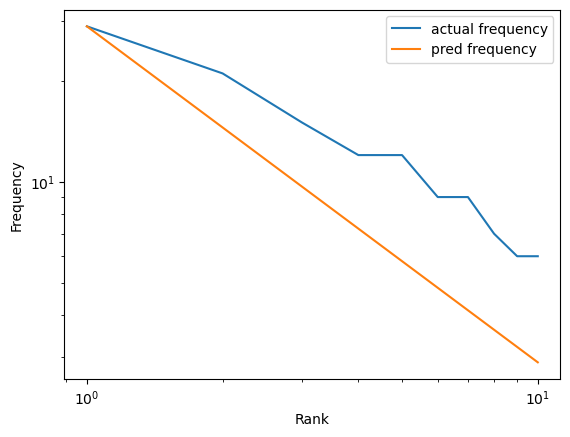

In [31]:
# your code here

#Zipfs for individual doc top 10 key words 
import matplotlib.pyplot as plt

print(df['DocumentID'][1])
print(df['token_freq'][1])
keys = df['token_freq'][1].keys()
vals = list(df['token_freq'][1].values())
print(keys)
print(vals)
p = {'keys': keys, 'vals': vals}
zif = pd.DataFrame(data=p)
zif.insert(0, 'rank', range(1, 1 + len(zif)))
zif
zif['rank * freq'] = zif['rank']*zif['vals']

mf = vals[0]
print(mf)

zif['opt'] = mf/(zif['rank'])

plt.xscale('log')
plt.yscale('log')

plt.plot(zif['rank'],zif['vals'],label='actual frequency')
plt.plot(zif['rank'],zif['opt'],label='pred frequency')


plt.xlabel('Rank')
plt.ylabel('Frequency')
#graph of optimal zipf distribution is plotted
leg = plt.legend(loc='upper right')
plt.show()

What do you observe? Explain.

*Add your discussion here.*

# Part 2: Boolean Retrieval (30 points)

In this part you will build an inverted index to support Boolean retrieval. You should use the (1) + (2) tokenization strategy from above (Remove background vocals + Lemmatization). 

We only require your index to support AND queries. In other words, your index does not have to support OR, NOT, or parentheses. Also, we do not explicitly expect to see AND in queries, e.g., when we query **relational model**, your search engine should treat it as **relational** AND **model**.

Search for the queries below using your index and print out matching documents (for each query, print out 5 matching documents):
* time
* never know
* make no sense

Recall, that you should apply the exact same pre-processing strategies to the query as we do to the documents. 

The output should like this:
* DocumentID Document

To make our life easier, please output the DocumentIDs in alphabetical order.

In [32]:
# build the index here
# add cells as needed to organize your code

#build inverse index

inv_index = defaultdict(list)
for doc, words in zip(
        df.DocumentID,
        df.Document_tokens.map(set)
    ):
    for word in words:
        inv_index[word].append(doc)
        
# search for the input using your index and print out ids of matching documents.

stemmer = snowball.SnowballStemmer('english')

def process_and_search(query):
    matched_documents = set()
    i = 0;
    for word in word_tokenize(query):
        word_lower = word.lower()
        matches = inv_index.get(word_lower)
        if matches and i == 0:
                i = i+1;
                temp_match_set = set(matches)
                matched_documents = set(matches)
        elif matches and i > 0:
                i = i+1;
                temp_match_set = set(matches)
                matched_documents &= set(matches)
    return matched_documents

Now show the results for the query: `time`

In [33]:
# search for the input using your index and print out ids of matching documents.
res = df.loc[df['DocumentID'].isin(process_and_search('time'))][['DocumentID','Document']]
res.sort_values(by = 'DocumentID', ascending=True).head()

,DocumentID,Document
94,5-seconds-of-summer-close-as-strangers-lyrics,six weeks since i've away say everything chang...
100,Alessia-cara-outlaws-lyrics,"run, run like devil’s behind us run one find u..."
157,Alicia-keys-fallin-lyrics,"keep fallin' outta love sometimes love ya, som..."
148,Alicia-keys-no-one-lyrics,want close stay forever sure get better togeth...
109,Anitta-goals-lyrics,"shine rest star watch awesome, unique time win..."


Now show the results for the query: `never know`


In [34]:
# your code here
res = df.loc[df['DocumentID'].isin(process_and_search('never know'))][['DocumentID','Document']]
res.sort_values(by = 'DocumentID', ascending=True).head()

,DocumentID,Document
61,2pac-u-r-ripping-us-apart-dedicated-2-crack-an...,u come triangle never break bond meld one 2 pu...
12,5-seconds-of-summer-heartbreak-girl-lyrics,"call up, like break record say heart hurt neve..."
100,Alessia-cara-outlaws-lyrics,"run, run like devil’s behind us run one find u..."
176,Alessia-cara-the-other-side-lyrics,"room, stay late i'm plan escape cause know can..."
49,Allie-x-sunflower-synth-reprise-lyrics,"rise girls glass vases perfect bodies, perfect..."


Now show the results for the query: `make no sense`

In [35]:
# your code here
res = df.loc[df['DocumentID'].isin(process_and_search('make no sense'))][['DocumentID','Document']]
res.sort_values(by = 'DocumentID', ascending=True).head()

,DocumentID,Document
151,Bring-me-the-horizon-mother-tongue-lyrics,see come never really much faith universe's ma...
165,Devlin-all-along-the-watchtower-lyrics,must way say joker thief there's much confusio...
115,Florence-the-machine-all-this-and-heaven-too-l...,heart hard translate language talk tongue quie...
149,Kid-cudi-ghost-lyrics,"yeah, woah-woah, oh yeah, woah-woah, haha yeah..."
195,Linkin-park-one-step-closer-lyrics,cannot take anymore say everything i've say wo...


## Observations (6 points)
Could your boolean search engine find relevant documents for these queries? What is the impact of the pre-processing options? Do they improve your search quality?

Yes, my boolean search engine can find relevant documents on the basis of given queries. The preprocessing has helped to remove unnecessary part of the document and generate useful tokens. It certainly enhances the search quality.

# Part 3: Ranking Documents (40 points) 

In this part, your job is to rank the documents rather than just provide set-based results as in Boolean Retrieval.

### A: Ranking with simple sums of TF-IDF scores (10 points) 
For a multi-word query, we rank documents by a simple sum of the TF-IDF scores for the query terms in the document.
TF is the log-weighted term frequency $1+log(tf)$; and IDF is the log-weighted inverse document frequency $log(\frac{N}{df})$

**Output:**
You should output the top-5 results plus the TF-IDF sum score of each of these documents. 

The output should be like this:

Rank Scores DocumentID Document 

In [36]:
tfidf2_temp = df
def tfidf_score_query(df,query):
    words = query.split()
    #save scores
    tfidf_scores = {}
    #doc and words and tdidfs
    doc_word_tfidf = {}
    #for all documents
    N = df['DocumentID'].size
    for i in range(N):  #traverse all documents
        tfidf = 0 #reset tfidf to 0 for every doc traversal
        tfidf_score_set_per_doc = {} #tfidf of the words is not calc yet
        for word in words: #check for all query words in the docs
            if word in df['token_freq_all'][i].keys():  # if the word is present in any of the doc keys
                tf = 1+math.log10((df['token_freq_all'][i][word]))  #calc TF by getting it's doc freq
                k = len(process_and_search(word)) #count num of docs it is present in
                idf = math.log10((N / k)) #calculate idf
                cur_tfidf = tf * idf # word specific tfidf
                tfidf += tf * idf #calculate tfidf
                tfidf_score_set_per_doc[word] = cur_tfidf #save the word's tfidf for this doc
        tfidf_scores[df['DocumentID'][i]] = tfidf #update tfidf once it is done
        doc_word_tfidf[df['DocumentID'][i]] = tfidf_score_set_per_doc
    # merge tfidf scores into df 
    res = dict(sorted(tfidf_scores.items(), key=lambda x:x[1], reverse= True))
    keys = res.keys()
    vals = res.values()
    res_dic = {'DocumentID': keys, 'score': vals}
    res_df = pd.DataFrame(data=res_dic)
    res_df.insert(0, 'rank', range(1, 1 + len(res_df)))
    merge_res = pd.merge(res_df, df, how='inner', on = 'DocumentID')
    #merge individual tfidf scores dictionary to df
    keys = doc_word_tfidf.keys()
    vals = doc_word_tfidf.values()
    res_dic = {'DocumentID': keys, 'individual tfidfs': vals}
    res_df = pd.DataFrame(data=res_dic)
    merge_res_2 = pd.merge(merge_res, res_df, how='inner', on = 'DocumentID')
    return merge_res_2



Now show the results for the query: `time`

In [37]:
# your code here
# hint: you could first call boolean retrieval function in part 2 to find possible relevant documents, 
# and then rank these documents in this part. Hence, you don't need to rank all documents.

#all docs and tfidfs for this query in descending order
res = tfidf_score_query(tfidf2_temp,'time')[['rank','score','DocumentID','Document']]

#map it to the boolean retrieval function
res.loc[res['DocumentID'].isin(process_and_search('time'))].head()

,rank,score,DocumentID,Document
0,1,0.997799,Derek-minor-until-the-end-of-time-lyrics,time fourth dimension measure events order pas...
1,2,0.938886,John-legend-for-the-first-time-lyrics,music ear like hear nothing thousand years eye...
2,3,0.900474,Method-man-if-time-is-money-fly-navigation-lyrics,"uh, yeah choose side look, vibe rhyme tricky, ..."
3,4,0.810657,Partynextdoor-not-nice-lyrics,oh-oh-oh-oh oh-oh-oh-oh get vacation time girl...
4,5,0.810657,Linkin-park-from-the-inside-lyrics,"know trust, surprise everyone feel far away he..."


Now show the results for the query: `never know`

In [38]:
# your code here

#all docs and tfidfs for this query in descending order
res = tfidf_score_query(tfidf2_temp,'never know')[['rank','score','DocumentID','Document']]

#map it to the boolean retrieval function
res.loc[res['DocumentID'].isin(process_and_search('never know'))].head()

,rank,score,DocumentID,Document
0,1,1.281561,Camila-cabello-never-be-the-same-remix-lyrics,something must've go wrong brain get chemicals...
1,2,1.246743,Skrillex-pretty-bye-bye-lyrics,"know trouble can't seem get away pleasure, pai..."
2,3,1.106321,Derek-minor-until-the-end-of-time-lyrics,time fourth dimension measure events order pas...
3,4,1.094269,Billie-eilish-8-lyrics,"wait minute, let finish know care listen? come..."
4,5,1.086254,Hozier-in-a-week-lyrics,never know peace like damp grass yield never k...


Now show the results for the query: `make no sense`

In [39]:
# your code here

#all docs and tfidfs for this query in descending order
res = tfidf_score_query(tfidf2_temp,'make no sense')[['rank','score','DocumentID','Document']]

#map it to the boolean retrieval function
res.loc[res['DocumentID'].isin(process_and_search('make no sense'))].head()

,rank,score,DocumentID,Document
0,1,4.066820,Bring-me-the-horizon-mother-tongue-lyrics,see come never really much faith universe's ma...
1,2,2.956421,Florence-the-machine-all-this-and-heaven-too-l...,heart hard translate language talk tongue quie...
2,3,2.768308,Kid-cudi-ghost-lyrics,"yeah, woah-woah, oh yeah, woah-woah, haha yeah..."
3,4,2.766704,Linkin-park-one-step-closer-lyrics,cannot take anymore say everything i've say wo...
4,5,2.429465,Devlin-all-along-the-watchtower-lyrics,must way say joker thief there's much confusio...


In [40]:
# extra query

# love talk

#all docs and tfidfs for this query in descending order
res = tfidf_score_query(tfidf2_temp,'love talk')[['rank','score','DocumentID','Document']]

#map it to the boolean retrieval function
res.loc[res['DocumentID'].isin(process_and_search('love talk'))].head()


,rank,score,DocumentID,Document
0,1,2.303714,The-weeknd-secrets-lyrics,"everybody want love, love know want 'em love, ..."
1,2,2.270365,Lido-angel-lyrics,"i'd love you, love you, angel feet grind i'd p..."
2,3,2.111992,Bryan-greenberg-you-can-run-lyrics,"run, run, can't hide...from love run, run, can..."
3,4,1.872408,5-seconds-of-summer-vapor-lyrics,"i'll take got, got, get know lot, lot, lot 'ca..."
4,5,1.603905,Lana-del-rey-beautiful-player-lyrics,"uh, what? starz, starz lana del rey, lana del ..."


### B: Ranking with vector space model with TF-IDF (10 points) 

**Cosine:** You should use cosine as your scoring function. 

**TFIDF:** For the document vectors, use the standard TF-IDF scores as introduced in A. For the query vector, use simple weights (the raw term frequency). For example:
* query: never $\rightarrow$ (1)
* query: never know $\rightarrow$ (1, 1)

**Output:**
You should output the top-5 results plus the cosine score of each of these documents.  

The output should be like this:

Rank Scores DocumentID Document 

---

You can additionally assume that your queries will contain at most three words. Be sure to normalize your vectors as part of the cosine calculation!

In [41]:
def tfidf_all_norm(dictn):
    tfidf = []
    N = df['DocumentID'].size
    for word in list(dictn.keys()):
        tf = 1 + math.log10((dictn[word]))  #calc TF by getting it's doc freq
        k = len(process_and_search(word)) #count num of docs it is present in
        if k>0:
            idf = math.log10((N / k)) #calculate idf
            cur_tfidf = tf * idf # word specific tfidf
            tfidf.append(cur_tfidf) #calculate tfidf
    return norm(tfidf)

Now show the results for the query: `time`

In [42]:
# your code here
query_vec = pd.Series([1])
norm_q = norm(query_vec)
vsm = tfidf_score_query(tfidf2_temp,'time')
vsm['len tfidfs'] = vsm['individual tfidfs'].apply(len)
vsm = vsm.loc[vsm['len tfidfs'] > 0]

#lets perform tfidf for all terms in the dictionary
vsm['norm doc all'] = vsm['token_freq_all'].apply(tfidf_all_norm)

vsm['cos_sim'] = vsm['score']/(norm_q*vsm['norm doc all'])
vsm = vsm.sort_values(by = 'cos_sim', ascending=False)
#map to boolean retrieval function
vsm = vsm.loc[vsm['DocumentID'].isin(process_and_search('time'))]
res = vsm[['cos_sim','DocumentID','Document']].head()
res.insert(0, 'rank', range(1, 1 + len(res)))
res

,rank,cos_sim,DocumentID,Document
1,1,0.102893,John-legend-for-the-first-time-lyrics,music ear like hear nothing thousand years eye...
19,2,0.096023,The-beatles-carry-that-weight-lyrics,"boy, gonna carry weight carry weight long time..."
41,3,0.080124,The-beatles-ill-follow-the-sun-lyrics,"one day, look see i've go tomorrow may rain, i..."
4,4,0.075603,Linkin-park-from-the-inside-lyrics,"know trust, surprise everyone feel far away he..."
7,5,0.075391,Lana-del-rey-burnt-norton-interlude-lyrics,time present time past perhaps present time fu...


Now show the results for the query: `never know`

In [43]:
# your code here
query_vec = pd.Series([1, 1])
norm_q = norm(query_vec)
vsm = tfidf_score_query(tfidf2_temp,'never know')
vsm['len tfidfs'] = vsm['individual tfidfs'].apply(len)
vsm = vsm.loc[vsm['len tfidfs'] > 0]

#lets perform tfidf for all terms in the dictionary
vsm['norm doc all'] = vsm['token_freq_all'].apply(tfidf_all_norm)

vsm['cos_sim'] = vsm['score']/(norm_q*vsm['norm doc all'])
vsm = vsm.sort_values(by = 'cos_sim', ascending=False)
#map to boolean retrieval function
vsm = vsm.loc[vsm['DocumentID'].isin(process_and_search('never know'))]
res = vsm[['cos_sim','DocumentID','Document']].head()
res.insert(0, 'rank', range(1, 1 + len(res)))
res

,rank,cos_sim,DocumentID,Document
9,1,0.089349,John-legend-made-to-love-lyrics,send make love make love send make love make l...
1,2,0.075480,Skrillex-pretty-bye-bye-lyrics,"know trouble can't seem get away pleasure, pai..."
3,3,0.066248,Billie-eilish-8-lyrics,"wait minute, let finish know care listen? come..."
0,4,0.061731,Camila-cabello-never-be-the-same-remix-lyrics,something must've go wrong brain get chemicals...
10,5,0.060912,Panic-at-the-disco-girls-girls-boys-lyrics,want hear get boyfriend sometimes better alone...


Now show the results for the query: `make no sense`

In [44]:
# your code here

query_vec = pd.Series([1, 1, 1])
norm_q = norm(query_vec)
vsm = tfidf_score_query(tfidf2_temp,'make no sense')
vsm['len tfidfs'] = vsm['individual tfidfs'].apply(len)
vsm = vsm.loc[vsm['len tfidfs'] > 0]

#lets perform tfidf for all terms in the dictionary
vsm['norm doc all'] = vsm['token_freq_all'].apply(tfidf_all_norm)

vsm['cos_sim'] = vsm['score']/(norm_q*vsm['norm doc all'])
vsm = vsm.sort_values(by = 'cos_sim', ascending=False)
#map to boolean retrieval function
vsm = vsm.loc[vsm['DocumentID'].isin(process_and_search('make no sense'))]
res = vsm[['cos_sim','DocumentID','Document']].head()
res.insert(0, 'rank', range(1, 1 + len(res)))
res

,rank,cos_sim,DocumentID,Document
0,1,0.156724,Bring-me-the-horizon-mother-tongue-lyrics,see come never really much faith universe's ma...
3,2,0.126247,Linkin-park-one-step-closer-lyrics,cannot take anymore say everything i've say wo...
1,3,0.108992,Florence-the-machine-all-this-and-heaven-too-l...,heart hard translate language talk tongue quie...
2,4,0.094501,Kid-cudi-ghost-lyrics,"yeah, woah-woah, oh yeah, woah-woah, haha yeah..."
4,5,0.058610,Devlin-all-along-the-watchtower-lyrics,must way say joker thief there's much confusio...


In [45]:
# extra query 
# love talk

query_vec = pd.Series([1, 1])
norm_q = norm(query_vec)
vsm = tfidf_score_query(tfidf2_temp,'love talk')
vsm['len tfidfs'] = vsm['individual tfidfs'].apply(len)
vsm = vsm.loc[vsm['len tfidfs'] > 0]

#lets perform tfidf for all terms in the dictionary
vsm['norm doc all'] = vsm['token_freq_all'].apply(tfidf_all_norm)

vsm['cos_sim'] = vsm['score']/(norm_q*vsm['norm doc all'])
vsm = vsm.sort_values(by = 'cos_sim', ascending=False)
#map to boolean retrieval function
vsm = vsm.loc[vsm['DocumentID'].isin(process_and_search('love talk'))]
res = vsm[['cos_sim','DocumentID','Document']].head()
res.insert(0, 'rank', range(1, 1 + len(res)))
res

,rank,cos_sim,DocumentID,Document
0,1,0.158757,The-weeknd-secrets-lyrics,"everybody want love, love know want 'em love, ..."
1,2,0.115568,Lido-angel-lyrics,"i'd love you, love you, angel feet grind i'd p..."
3,3,0.110239,5-seconds-of-summer-vapor-lyrics,"i'll take got, got, get know lot, lot, lot 'ca..."
2,4,0.109279,Bryan-greenberg-you-can-run-lyrics,"run, run, can't hide...from love run, run, can..."
6,5,0.081663,Miley-cyrus-if-we-were-a-movie-lyrics,"uh oh go again, talk cinematic yeah, charm get..."


### C: Ranking with BM25 (10 points) 
Finally, let's try the BM25 approach for ranking. Refer to https://en.wikipedia.org/wiki/Okapi_BM25 for the specific formula. You could choose k_1 = 1.2 and b = 0.75 but feel free to try other options.

**Output:**
You should output the top-5 results plus the BM25 score of each of these documents.  

The output should be like this:

Rank Scores DocumentID Document

In [46]:
#BM25 formula

# lets say Q => q1, q2 ... qn
# f(q1, d) => freq of q1 word in doc d

# IDF calculation code for a particular word in a doc is as follows:

#     N = df['DocumentID'].size
#     for word in words: #check for all query words in the docs
#         if word in df['token_freq_all'][i].keys():  # if the word is present in any of the doc keys
#             k = len(process_and_search(word)) #count num of docs it is present in
#             df = math.log10((N / k)) #calculate idf

# lets take k_1 = 1.2 and b = 0.75

# |D| => len_d => no of tokens in the document => present in df['count_words'] 

# avgdl is the average document length in the text collection from which documents 

In [47]:
avgdl = df['count_words'].mean()
bm25_temp = df
def bm25_score_query(df,query):
    words = query.split()
    k_1 = 1.2
    b = 0.75
    #save scores
    tfidf_scores = {}
    #doc and words and tdidfs
    N = df['DocumentID'].size
    for i in range(N):  #traverse all documents
        bm25_score = 0
        len_d = df['count_words'][i] #count num of tokens in the doc -> len of the doc 
        for word in words: #check for all query words in the docs
            
            if word in df['token_freq_all'][i].keys():  # if the word is present in any of the doc keys
                docs_count_for_word = len(process_and_search(word)) #count num of docs it is present in
                idf = math.log10((N / docs_count_for_word)) #calculate idf
                freq = df['token_freq_all'][i][word]
                cur_score = (idf) * (freq * (k_1 + 1)) / (freq + ( (1-b)+(b * (len_d/avgdl)) ) )
                bm25_score += cur_score
        tfidf_scores[df['DocumentID'][i]] = bm25_score
    # merge tfidf scores into df 
    res = dict(sorted(tfidf_scores.items(), key=lambda x:x[1], reverse= True))
    keys = res.keys()
    vals = res.values()
    res_dic = {'DocumentID': keys, 'BM25_score': vals}
    res_df = pd.DataFrame(data=res_dic)
    res_df.insert(0, 'rank', range(1, 1 + len(res_df)))
    merge_res = pd.merge(res_df, df, how='inner', on = 'DocumentID')
    return merge_res

Now show the results for the query: `time`

In [48]:
# your code here
bm25_score_query(bm25_temp,'time')[['rank','BM25_score','DocumentID','Document']].head()

,rank,BM25_score,DocumentID,Document
0,1,0.889587,John-legend-for-the-first-time-lyrics,music ear like hear nothing thousand years eye...
1,2,0.883496,Lana-del-rey-burnt-norton-interlude-lyrics,time present time past perhaps present time fu...
2,3,0.863803,Sza-pray-lyrics,"pray one time one time, time young medusa neve..."
3,4,0.861525,System-of-a-down-thetawaves-lyrics,unsettle mind time ally leave sense fend sense...
4,5,0.850389,Linkin-park-from-the-inside-lyrics,"know trust, surprise everyone feel far away he..."


Now show the results for the query: `never know`

In [49]:
# your code here
bm25_score_query(bm25_temp,'never know')[['rank','BM25_score','DocumentID','Document']].head()

,rank,BM25_score,DocumentID,Document
0,1,1.245271,Skrillex-pretty-bye-bye-lyrics,"know trouble can't seem get away pleasure, pai..."
1,2,1.232977,Billie-eilish-8-lyrics,"wait minute, let finish know care listen? come..."
2,3,1.222242,Camila-cabello-never-be-the-same-remix-lyrics,something must've go wrong brain get chemicals...
3,4,1.205499,Green-day-macys-day-parade-lyrics,today's macy's day parade night live dead way ...
4,5,1.177982,John-legend-made-to-love-lyrics,send make love make love send make love make l...


Now show the results for the query: `make no sense`

In [50]:
# your code here
bm25_score_query(bm25_temp,'make no sense')[['rank','BM25_score','DocumentID','Document']].head()

,rank,BM25_score,DocumentID,Document
0,1,4.037874,Bring-me-the-horizon-mother-tongue-lyrics,see come never really much faith universe's ma...
1,2,3.302333,Florence-the-machine-all-this-and-heaven-too-l...,heart hard translate language talk tongue quie...
2,3,3.174221,Linkin-park-one-step-closer-lyrics,cannot take anymore say everything i've say wo...
3,4,2.939342,Kid-cudi-ghost-lyrics,"yeah, woah-woah, oh yeah, woah-woah, haha yeah..."
4,5,2.568471,System-of-a-down-thetawaves-lyrics,unsettle mind time ally leave sense fend sense...


In [51]:
# extra query
# love talk
bm25_score_query(bm25_temp,'love talk')[['rank','BM25_score','DocumentID','Document']].head()


,rank,BM25_score,DocumentID,Document
0,1,2.413119,The-weeknd-secrets-lyrics,"everybody want love, love know want 'em love, ..."
1,2,2.311317,Lido-angel-lyrics,"i'd love you, love you, angel feet grind i'd p..."
2,3,2.183826,Bryan-greenberg-you-can-run-lyrics,"run, run, can't hide...from love run, run, can..."
3,4,2.064341,5-seconds-of-summer-vapor-lyrics,"i'll take got, got, get know lot, lot, lot 'ca..."
4,5,1.718596,Red-hot-chili-peppers-shes-only-18-lyrics,18 like roll stone take short cut fully grow g...


### Discussion (10 points)
Briefly discuss the differences you see between the three methods. You should try additional queries beyond the ones we list. Is there a ranking approach you prefer? Explain and give concrete examples.


# Part 4: Cool Extension (10 points) 

Finally, we give you an opportunity to explore some more sophisticated approach to your search engine. This is your chance to show off something you find interesting. For example, you might:


*   Add a positional index so you can support phrase queries
*   Implement a permuterm index for wildcard queries
*   Incorporate spell correction
*   Index all of the lyrics at https://www.cs.cornell.edu/~arb/data/genius-expertise/ and demonstrate an efficient implementation
*   Try a more advanced ranking approach
*   ...

We will grade this last part according to effort, creativity, and impact.



### 1)Spell Correction

In [52]:
from textblob import TextBlob
query = TextBlob('firsty dayy to codee!')
result = query.correct()
print(result)

first day to code!


### 2)Phrase Match

In [53]:
import spacy
df_temp = df
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import PhraseMatcher
phrase_matcher = PhraseMatcher(nlp.vocab)
phrases = ['never know']
patterns = [nlp(text) for text in phrases]
phrase_matcher.add('AI', None, *patterns)
df_temp['nlp'] = df_temp['Document'].apply(nlp)
df_temp['matched_phrases'] = df_temp['nlp'].apply(phrase_matcher)
df_temp['count_matches'] = df_temp['matched_phrases'].apply(len)
df_temp.loc[ df_temp['count_matches'] > 0]

,DocumentID,Document,Document_tokens,count_words,token_freq,token_freq_all,nlp,matched_phrases,count_matches
21,Hozier-in-a-week-lyrics,never know peace like damp grass yield never k...,"[i, have, never, know, peace, like, the, damp,...",334,"{''d': 18, 'i': 17, 'the': 17, 'have': 12, 'yo...","{''d': 18, 'i': 17, 'the': 17, 'have': 12, 'yo...","(never, know, peace, like, damp, grass, yield,...","[(5530044837203964789, 0, 2), (553004483720396...",4
36,Marina-the-archetypes-lyrics,"housewife, beauty queen, homewrecker, idle tee...","[housewife, ,, beauty, queen, ,, homewrecker, ...",96,"{',': 7, 'a': 6, 'be': 4, '?': 3, 'i': 3, 'you...","{',': 7, 'a': 6, 'be': 4, '?': 3, 'i': 3, 'you...","(housewife, ,, beauty, queen, ,, homewrecker, ...","[(5530044837203964789, 41, 43), (5530044837203...",2
59,Miley-cyrus-if-we-were-a-movie-lyrics,"uh oh go again, talk cinematic yeah, charm get...","[uh, oh, there, you, go, again, ,, talk, cinem...",345,"{',': 23, 'the': 21, 'be': 19, 'you': 17, ''d'...","{',': 23, 'the': 21, 'be': 19, 'you': 17, ''d'...","(uh, oh, go, again, ,, talk, cinematic, yeah, ...","[(5530044837203964789, 72, 74)]",1
115,Florence-the-machine-all-this-and-heaven-too-l...,heart hard translate language talk tongue quie...,"[and, the, heart, be, hard, to, translate, it,...",361,"{'i': 23, 'and': 22, 'it': 19, 'all': 17, 'the...","{'i': 23, 'and': 22, 'it': 19, 'all': 17, 'the...","(heart, hard, translate, language, talk, tongu...","[(5530044837203964789, 152, 154)]",1
117,Billie-eilish-8-lyrics,"wait minute, let finish know care listen? come...","[wait, a, minute, ,, let, me, finish, i, know,...",214,"{'i': 21, 'you': 15, ',': 11, 'me': 7, 'hmm': ...","{'i': 21, 'you': 15, ',': 11, 'me': 7, 'hmm': ...","(wait, minute, ,, let, finish, know, care, lis...","[(5530044837203964789, 74, 76), (5530044837203...",2
132,Green-day-macys-day-parade-lyrics,today's macy's day parade night live dead way ...,"[today, 's, the, macy, 's, day, parade, the, n...",225,"{'i': 21, 'the': 14, ''s': 7, 'a': 7, 'it': 6,...","{'i': 21, 'the': 14, ''s': 7, 'a': 7, 'it': 6,...","(today, 's, macy, 's, day, parade, night, live...","[(5530044837203964789, 73, 75), (5530044837203...",4


# Collaboration Declarations

** You should fill out your collaboration declarations here.**

**Reminder:** You are expected to complete each homework independently. Your solution should be written by you without the direct aid or help of anyone else. However, we believe that collaboration and team work are important for facilitating learning, so we encourage you to discuss problems and general problem approaches (but not actual solutions) with your classmates. You may post on Piazza, search StackOverflow, etc. But if you do get help in this way, you must inform us by filling out the Collaboration Declarations at the bottom of this notebook.

Example: I found helpful code on stackoverflow at https://stackoverflow.com/questions/11764539/writing-fizzbuzz that helped me solve Problem 2.